# **Preprocessing of the DIOR-R Dataset**

The [DIOR-R](https://gcheng-nwpu.github.io/#Datasets) dataset is a benchmark dataset for object detection in optical remote sensing images. Optical remote sensing captures high-resolution images with specific details of the Earth's surface, showing colors and shapes similar to what we would see with the naked eye. This level of detail is essential for capturing the visual characteristics and specific structures of objects in terrestrial environments, enabling the training of advanced object detection models for aerial and satellite images.

The DIOR-R dataset includes 23,463 images and 192,518 instances annotated with oriented bounding boxes (OBB), which is particularly useful in optical remote sensing, as views from satellites or drones often show objects in varying orientations due to the observation angle. The dataset contains 20 object classes and is divided into 5,862 images for training, 5,863 for validation, and 11,738 for testing.

## **Imports**

In [ ]:
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import plotly.express as px
from google.colab import drive
import xml.etree.ElementTree as ET
from glob import glob
from tqdm.auto import tqdm
import pandas as pd
import shutil
import os

In [ ]:
# Mount Google Drive in Colab
drive.mount("/content/drive")

Mounted at /content/drive


## **Parameters**

The complete official dataset is available on this [Google Drive](https://drive.google.com/open?id=1UdlgHk49iu6WpcJ5467iT-UqNPpx__CC). I have added this raw dataset as a shortcut in my personal Google Drive, in a folder named `Raw_DIOR`, for further preprocessing.

In [ ]:
raw_dataset_path = "/content/drive/MyDrive/Datasets/Raw_DIOR"
dataset_path = "/content/DIOR-R"
zip_data_path = "/content/drive/MyDrive/Datasets/DIOR-R.zip"

os.makedirs(dataset_path, exist_ok=True)

## **Unzip the Dataset**

In [ ]:
!unzip -q {os.path.join(raw_dataset_path, "ImageSets.zip")}
!unzip -q {os.path.join(raw_dataset_path, "Annotations.zip")}
!unzip -q {os.path.join(raw_dataset_path, "JPEGImages-trainval.zip")}
!unzip -q {os.path.join(raw_dataset_path, "JPEGImages-test.zip")}

## **Preprocess the Dataset**

The dataset classes are sourced from its [official paper](https://arxiv.org/pdf/1909.00133). Additionally, some classes are misspelled in the annotations, so they are normalized to match the names specified in the paper.

In [ ]:
# Create a list of the class names
class_names = [
    "airplane", "airport", "baseball field", "basketball court", "bridge",
    "chimney", "dam", "expressway service area", "expressway toll station", "golf course",
    "ground track field", "harbor", "overpass", "ship", "stadium",
    "storage tank", "tennis court", "train station", "vehicle", "wind mill"
]

num_classes = len(class_names)
print(num_classes)
print(class_names)

20
['airplane', 'airport', 'baseball field', 'basketball court', 'bridge', 'chimney', 'dam', 'expressway service area', 'expressway toll station', 'golf course', 'ground track field', 'harbor', 'overpass', 'ship', 'stadium', 'storage tank', 'tennis court', 'train station', 'vehicle', 'wind mill']


In [ ]:
# Dictionary for normalizing class names
norm_classes = {
    "baseballfield": "baseball field",
    "basketballcourt": "basketball court",
    "golffield": "golf course",
    "groundtrackfield": "ground track field",
    "storagetank": "storage tank",
    "tenniscourt": "tennis court",
    "trainstation": "train station",
    "windmill": "wind mill"
}

In [ ]:
# Function to find the paths of the images and annotations

def find_paths(split="train"):
  with open(f"/content/Main/{split}.txt", "r") as f:
    ids = [line.strip() for line in f.readlines()]

    images = sorted([
        os.path.join(f"/content/JPEGImages-{'test' if split == 'test' else 'trainval'}", f"{id}.jpg")
        for id in ids
    ])
    annotations = sorted([
        os.path.join("/content/Annotations/Oriented Bounding Boxes", f"{id}.xml")
        for id in ids
    ])

  return images, annotations

In [ ]:
train_images, train_annotations = find_paths(split="train")
val_images, val_annotations = find_paths(split="val")
test_images, test_annotations = find_paths(split="test")

print(len(train_images), len(train_annotations))
print(len(val_images), len(val_annotations))
print(len(test_images), len(test_annotations))

5862 5862
5863 5863
11738 11738


In [ ]:
# Function to extract the classes and coordinates of the OBB
def parse_annotation(xml_file):
  tree = ET.parse(xml_file)
  root = tree.getroot()

  # Extract the dimensions of the image
  width_img = int(root.find("size").find("width").text)
  height_img = int(root.find("size").find("height").text)

  # Initialize the label variable with an empty set to avoid duplicate rows
  labels = set()
  for obj in root.iter("object"):
    # Find the ID of each class
    cls = obj.find("name").text
    cls = cls.replace("-", " ").lower()
    cls = norm_classes[cls] if cls in norm_classes else cls
    cls = class_names.index(cls)

    # Extract the coordinates of the OBB
    polygon = obj.find("robndbox")

    # Normalize the coordinates to the YOLO OBB format
    x1 = float(polygon.find("x_left_top").text) / width_img
    y1 = float(polygon.find("y_left_top").text) / height_img
    x2 = float(polygon.find("x_right_top").text) / width_img
    y2 = float(polygon.find("y_right_top").text) / height_img
    x3 = float(polygon.find("x_right_bottom").text) / width_img
    y3 = float(polygon.find("y_right_bottom").text) / height_img
    x4 = float(polygon.find("x_left_bottom").text) / width_img
    y4 = float(polygon.find("y_left_bottom").text) / height_img

    # Normalize the coordinates in the range [0;1]
    polygon = np.clip([x1, y1, x2, y2, x3, y3, x4, y4], 0, 1)

    labels.add((cls, *polygon))

  return labels

In [ ]:
# Function to save the images and labels
def save_dataset(images, annotations, name="train"):
  data_path = os.path.join(dataset_path, name)
  images_path = os.path.join(data_path, "images")
  labels_path = os.path.join(data_path, "labels")

  os.makedirs(data_path, exist_ok=True)
  os.makedirs(images_path, exist_ok=True)
  os.makedirs(labels_path, exist_ok=True)

  for image, annotation in tqdm(zip(images, annotations), total=len(images)):
    label = parse_annotation(annotation)
    id = image.split("/")[-1].split(".")[0]

    # Discard the empty annotations
    if len(label) > 0:
      # Save the image
      shutil.copy(image, os.path.join(images_path, f"{id}.jpg"))

      # Save the label
      # It is more versatile than np.savetxt as it allows saving a variable number of decimals
      with open(os.path.join(labels_path, f"{id}.txt"), "w") as f:
        for row in label:
          f.write(f"{' '.join([str(e) for e in row])}\n")

    else:
      print(f"Empty annotation: {annotation}\n")

In [ ]:
save_dataset(train_images, train_annotations)
save_dataset(val_images, val_annotations, name="val")
save_dataset(test_images, test_annotations, name="test")

  0%|          | 0/5862 [00:00<?, ?it/s]

  0%|          | 0/5863 [00:00<?, ?it/s]

  0%|          | 0/11738 [00:00<?, ?it/s]

It can be observed that there were no empty annotations.

In [ ]:
# Create the YAML files with the dataset metadata

# To evaluate the validation dataset
with open(os.path.join(dataset_path, "data_val.yaml"), "w") as f:
  f.write(f"""
  path: DIOR-R
  train: train/images
  val: val/images
  test: test/images

  nc: {num_classes}
  names: {class_names}
  """)

# To evaluate the test dataset
with open(os.path.join(dataset_path, "data_test.yaml"), "w") as f:
  f.write(f"""
  path: DIOR-R
  train: train/images
  val: test/images
  test: val/images

  nc: {num_classes}
  names: {class_names}
  """)

In [ ]:
# Compress the dataset into a zip file and save it
!zip -r $zip_data_path DIOR-R -q

## **Visualization Example**

In [ ]:
colors = [
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd",
    "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf",
    "#9edae5", "#ff9896", "#c5b0d5", "#aec7e8", "#ffbb78",
    "#98df8a", "#ff6347", "#ff1493", "#20b2aa", "#800080"
]

In [ ]:
#Function to plot images with OBB
def plot_image_annotation(id, with_legend=False):
  fig, ax = plt.subplots(1, figsize=(12, 12))

  image = Image.open(f"/content/DIOR-R/train/images/{id}.jpg")
  shape = np.array(image).shape
  ax.imshow(image)

  annotation = np.loadtxt(f"/content/DIOR-R/train/labels/{id}.txt")
  annotation = annotation[None, :] if annotation.ndim == 1 else annotation
  classes = annotation[:, 0].astype(np.int32)
  boxes = annotation[:, 1:]

  for i in range(len(boxes)):
    cls = classes[i]

    box = boxes[i].reshape((-1, 2))
    box[:, 0] *= shape[1]
    box[:, 1] *= shape[0]

    # Convert the polygon to a minimum area rectangle (x_center, y_center, width, height, angle)
    box = cv2.minAreaRect(box.astype(np.int32))
    angle = box[-1]

    # Find the 4 vertices of the rotated rectangle
    box = cv2.boxPoints(box)

    rect = patches.Polygon(box, linewidth=1.5, edgecolor=colors[cls], facecolor="none")
    ax.add_patch(rect)

    if not with_legend:
      ax.text(
          x=box[0, 0], y=box[0, 1], s=class_names[cls],
          color="black", fontsize=5.75, fontweight="bold", ha="left", va="bottom",
          bbox={"boxstyle": "square,pad=0.1", "facecolor": colors[cls], "edgecolor": colors[cls], "alpha": 0.7},
          rotation=90-angle
      )

  if with_legend:
    legend_elements = [
        patches.Patch(color=colors[cls], label=class_names[cls])
        for cls in np.unique(classes)
    ]
    ax.legend(handles=legend_elements, loc="upper right", fontsize=7)

  ax.axis("off");

In [ ]:
id = "00100"

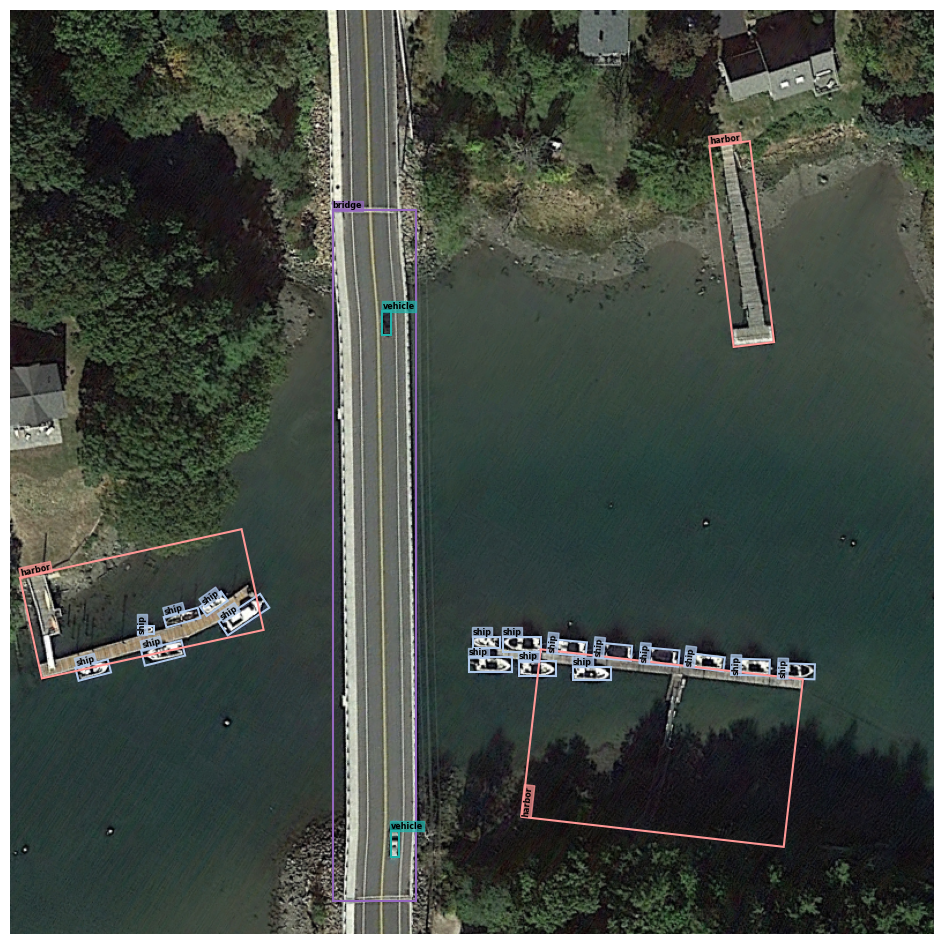

In [ ]:
plot_image_annotation(id)

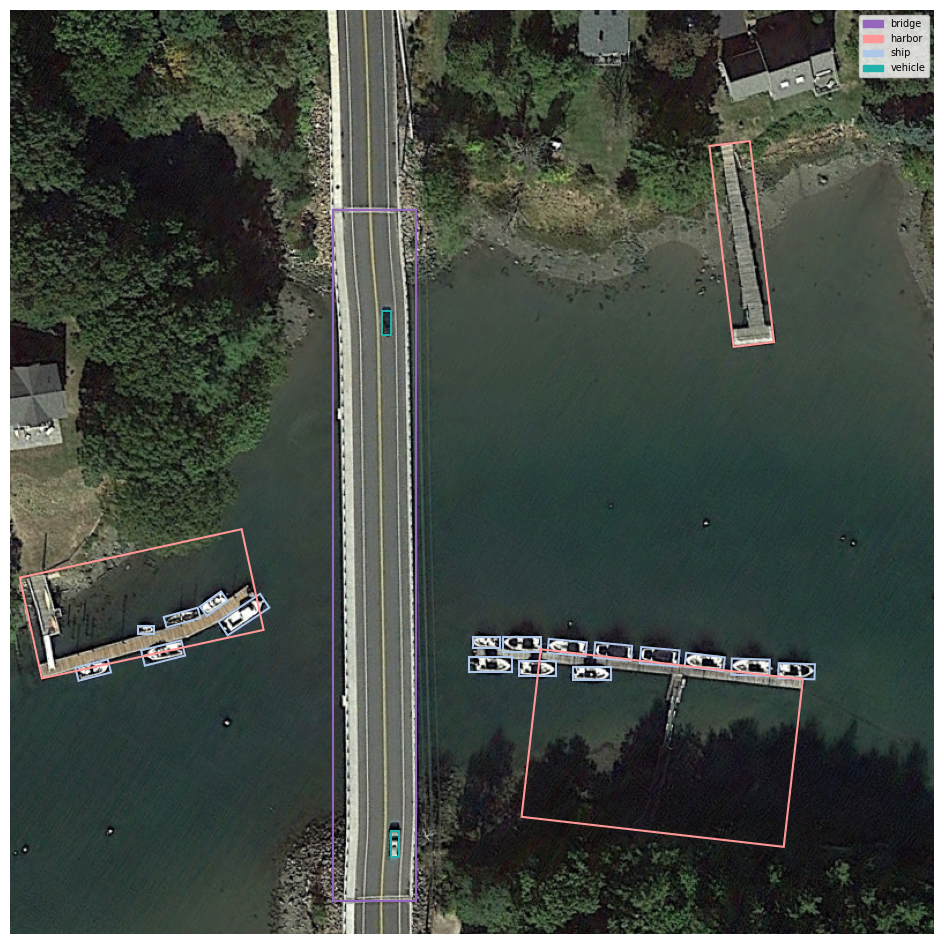

In [ ]:
plot_image_annotation(id, with_legend=True)

## **Exploratory Data Analysis (EDA)**

In [ ]:
# Function to extract instance counts per class
def count_instances(path_data):
  dic_classes = {name: 0 for name in class_names}
  labels = glob(os.path.join(path_data, "labels/*.txt"))

  for label in tqdm(labels):
    ids = np.loadtxt(label)
    ids = ids[None, :][:, 0] if ids.ndim == 1 else ids[:, 0]
    names = np.array(class_names)[ids.astype(np.int32)]

    for name in names:
      dic_classes[name] += 1

  df = pd.DataFrame(list(dic_classes.items()), columns=["Class", "Count"])
  return df

In [ ]:
num_train_instances = count_instances(os.path.join(dataset_path, "train"))
num_val_instances = count_instances(os.path.join(dataset_path, "val"))
num_test_instances = count_instances(os.path.join(dataset_path, "test"))

  0%|          | 0/5862 [00:00<?, ?it/s]

  0%|          | 0/5863 [00:00<?, ?it/s]

  0%|          | 0/11738 [00:00<?, ?it/s]

In [ ]:
# Library needed to convert Plotly interactive graphics into images
!pip install kaleido -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 8.8 MB/s eta 0:00:00


In [ ]:
# Function to plot a barplot of class counts
def plot_counts(num_instances, split="training", renderer=None):
  num_instances = num_instances.sort_values(by="Count")
  fig = px.bar(
      num_instances, x="Count", y="Class", title="Counts of Classes",
      text="Count", color="Count",
      color_continuous_scale=[(0, "#D80000"), (0.5, "lightblue"), (1, "#003299")]
  )

  fig.update_layout(
      title=dict(text=f"Class Count in the {split.capitalize()} Set", font=dict(size=16, weight="bold"), x=0.5),
      xaxis_title=dict(text="Frequency", font=dict(size=12, weight="bold")),
      yaxis_title=dict(text="Class", font=dict(size=12, weight="bold")),
      height=600,
      width=1200
  )
  fig.show(renderer=renderer)

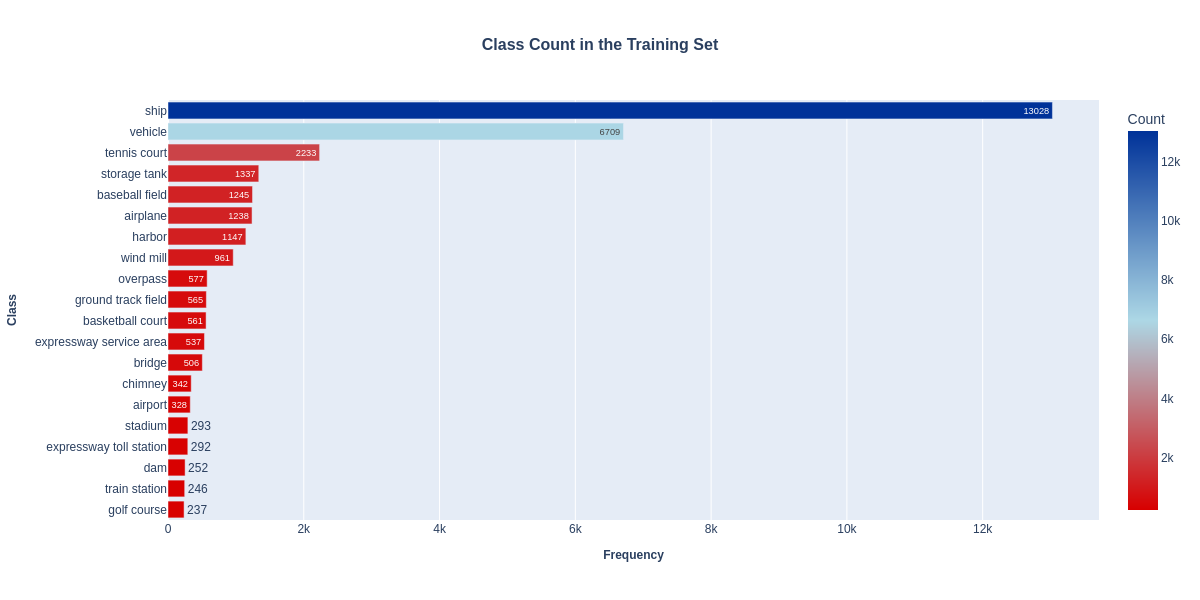

In [ ]:
#plot_counts(num_train_instances) In this case, it is not strictly necessary to create interactive graphs
plot_counts(num_train_instances, renderer="png")

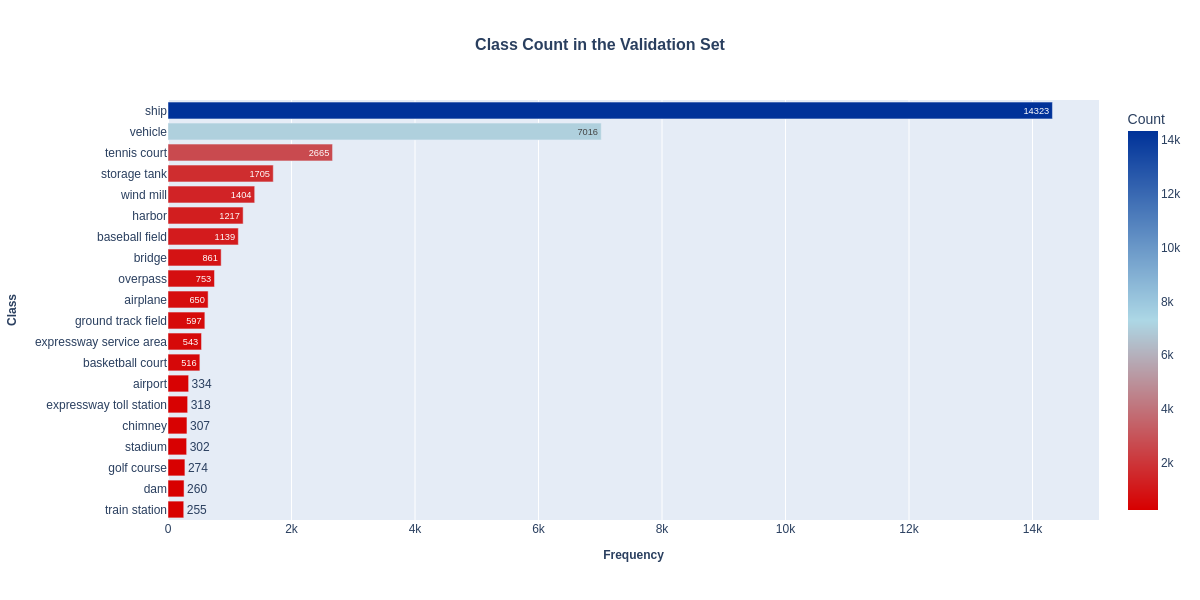

In [ ]:
#plot_counts(num_val_instances, split="validation")
plot_counts(num_val_instances, split="validation", renderer="png")

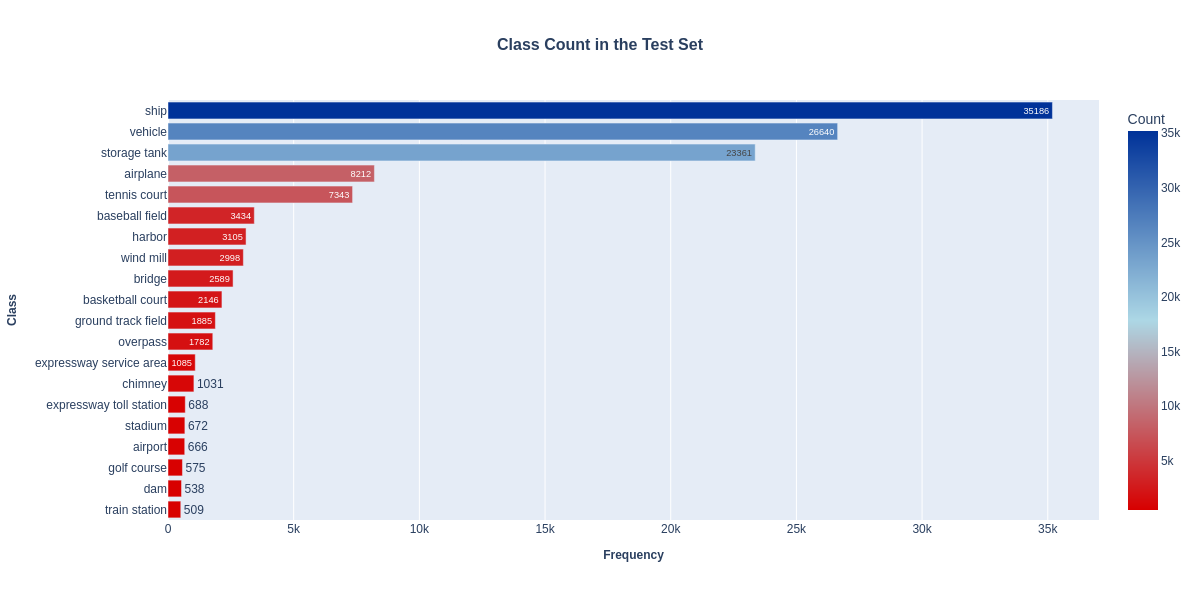

In [ ]:
#plot_counts(num_test_instances, split="test")
plot_counts(num_test_instances, split="test", renderer="png")

In [ ]:
# Create a DataFrame containing the most important metrics
num_total_instances = num_train_instances.Count + num_val_instances.Count + num_test_instances.Count
df_instances = pd.DataFrame({
    "Class": class_names,
    "TrainCount": num_train_instances.Count,
    "ValCount": num_val_instances.Count,
    "TestCount": num_test_instances.Count,
    "TotalCount": num_total_instances,
    "TrainRatio": (num_train_instances.Count / num_total_instances) * 100,
    "ValRatio": (num_val_instances.Count / num_total_instances) * 100,
    "TestRatio": (num_test_instances.Count / num_total_instances) * 100
})

df_instances.sort_values(by="ValRatio", ascending=False)

Class  TrainCount  ValCount  TestCount  TotalCount  \
19                wind mill         961      1404       2998        5363   
17            train station         246       255        509        1010   
9               golf course         237       274        575        1086   
1                   airport         328       334        666        1328   
7   expressway service area         537       543       1085        2165   
6                       dam         252       260        538        1050   
8   expressway toll station         292       318        688        1298   
12                 overpass         577       753       1782        3112   
14                  stadium         293       302        672        1267   
13                     ship       13028     14323      35186       62537   
11                   harbor        1147      1217       3105        5469   
16             tennis court        2233      2665       7343       12241   
4                    bridge         506       861       2589        3956   
10       ground track field         565       597       1885        3047   
2            baseball field        1245      1139       3434        5818   
5                   chimney         342       307       1031        1680   
18                  vehicle        6709      7016      26640       40365   
3          basketball court         561       516       2146        3223   
15             storage tank        1337      1705      23361       26403   
0                  airplane        1238       650       8212       10100   

    TrainRatio   ValRatio  TestRatio  
19   17.919075  26.179377  55.901548  
17   24.356436  25.247525  50.396040  
9    21.823204  25.230203  52.946593  
1    24.698795  25.150602  50.150602  
7    24.803695  25.080831  50.115473  
6    24.000000  24.761905  51.238095  
8    22.496148  24.499230  53.004622  
12   18.541131  24.196658  57.262211  
14   23.125493  23.835833  53.038674  
13   20.832467  22.903241  56.264292  
11   20.972756  22.252697  56.774547  
16   18.241974  21.771097  59.986929  
4    12.790698  21.764408  65.444894  
10   18.542829  19.593042  61.864129  
2    21.399106  19.577174  59.023719  
5    20.357143  18.273810  61.369048  
18   16.620835  17.381395  65.997770  
3    17.406143  16.009929  66.583928  
15    5.063819   6.457600  88.478582  
0    12.257426   6.435644  81.306931

In [ ]:
df_instances.TotalCount.sum()

192518

It can be observed that the three datasets are not balanced in terms of the number of instances per class. The majority classes are `ship` and `vehicle`, while the minority classes are `dam`, `train station`, and `golf course`. When fine-tuning a **YOLO11 OBB** model from Ultralytics on this dataset, it is expected that the performance on these three minority classes would be extremely low due to the class imbalance. However, this issue is mitigated by the distributional focal loss (DFL), which helps balance the contribution of minority classes. Furthermore, it is observed that the training and validation datasets have approximately the same percentage of instances relative to the total for all classes, while the test dataset contains more than 50% of the instances for all classes. Therefore, the model's performance during evaluation may vary between the validation and test datasets.